# VASP CdTe benchmark performance

This notebook compares the performance of the CdTe benchmark (hybrid DFT, exact exchange) between ARCHER and ARCHER2 and for VASP compiled with different numerical libraries on ARCHER2.

We compute performance using the maximum time per SCF cycle from all cycles in the output file. The maximum is used as SCF cycles are non-homogeneous in this VASP benchmark with extra work being done in the later SCF cycles. In the full calculation from which this benchmark is extracted, the long SCF cycles make up the majority of the cycles and dominate the runtime.

Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds).

All calculations were performed with VASP 5.4.4.pl2:

- On ARCHER: Intel Compilers 17, FFTW, Intel MKL 17
- On ARCHER2: GCC 10.1.0, FFTW 3.3.8.8, HPE Cray MPICH 8.0.16 and various numerical libraries

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
results = ['ARCHER', 'ARCHER2_LibSci-20.10','ARCHER2_MKL-19.5','ARCHER2_MKL-21.2','ARCHER2_AOCL-3.0']
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2_LibSci-20.10': 'ARCHER',
    'ARCHER2_MKL-19.5': 'ARCHER2',
    'ARCHER2_MKL-21.2': 'ARCHER2',
    'ARCHER2_AOCL-3.0': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../CdTe_Hybrid/results/' + res
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
8     192       1       12   2     0.000169  0.000169  0.000169  0.000169   
16    384       1       8    2     0.000272  0.000272  0.000272  0.000272   
                        24   2     0.000328  0.000328  0.000328  0.000328   
32    768       1       8    2     0.000217  0.000217  0.000217  0.000217   
                        48   2     0.000599  0.000599  0.000599  0.000599   
50    1200      1       75   2     0.000900  0.000900  0.000900  0.000900   
64    1536      1       96   2     0.000983  0.000983  0.000983  0.000983   

                                         SCF                                   \
                                         min     median        max       mean   
Nodes Processes Threads NPAR KPAR                          

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       4    2     0.000090  0.000090  0.000090  0.000090   
                        8    2     0.000089  0.000089  0.000089  0.000089   
                        16   2     0.000097  0.000097  0.000097  0.000097   
2     256       1       4    2     0.000142  0.000142  0.000142  0.000142   
                        8    2     0.000178  0.000178  0.000178  0.000178   
                        16   2     0.000134  0.000134  0.000134  0.000134   
                        32   2     0.000183  0.000183  0.000184  0.000183   
4     512       1       8    2     0.000281  0.000281  0.000281  0.000281   
                        16   2     0.000319  0.000319  0.000319  0.000319   
                        32   2     0.000292  0.000292  0.000292  0.000292   

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       32   2     0.000072  0.000072  0.000072  0.000072   
2     256       1       32   2     0.000168  0.000168  0.000168  0.000168   
                        64   2     0.000129  0.000129  0.000129  0.000129   
4     512       1       64   2     0.000318  0.000318  0.000318  0.000318   
8     1024      1       128  2     0.000566  0.000568  0.000570  0.000568   
16    2048      1       64   2     0.000934  0.000934  0.000934  0.000934   
32    4096      1       128  2     0.001515  0.001515  0.001515  0.001515   
64    8192      1       256  2     0.002104  0.002104  0.002104  0.002104   

                                          SCF                           \
                                          min       median         max   
Node

## Performance Comparison

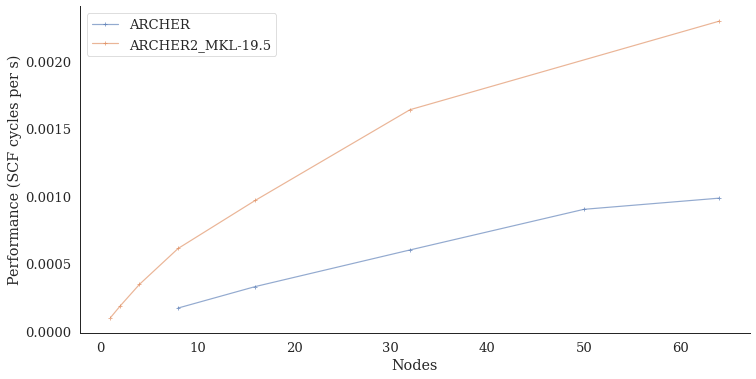

In [6]:
results = ['ARCHER','ARCHER2_MKL-19.5']
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)

plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

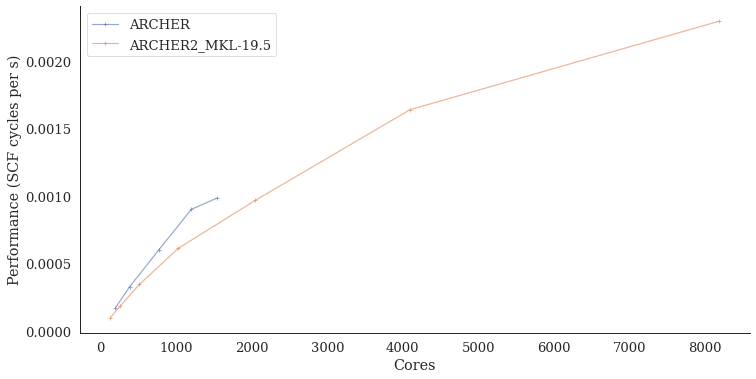

In [7]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

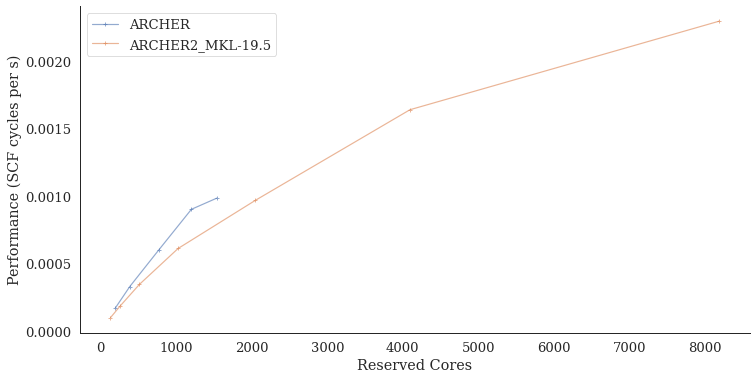

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2 numerical libraries performance comparison

This section compares the performance of this VASP benchmark for VASP compiled with various numerical libraries. Apart from the numerical libraries themselves all versions of VASP were compiled with GCC 10.1.0, FFTW 3.3.8.8 and HPE Cray MPICH 8.0.16.

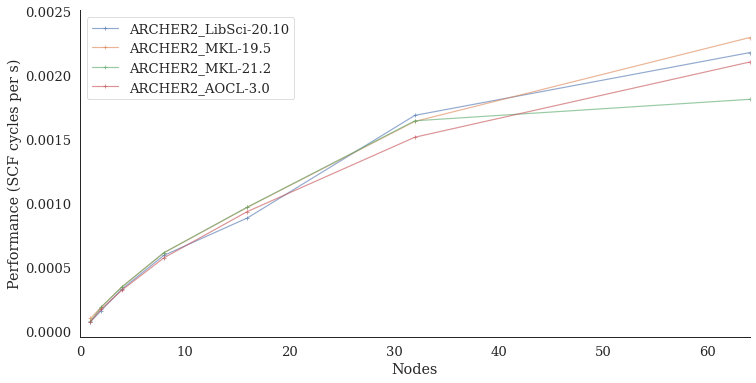

In [9]:
results = ['ARCHER2_LibSci-20.10','ARCHER2_MKL-19.5','ARCHER2_MKL-21.2','ARCHER2_AOCL-3.0']
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.xlim((0,64))
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('vasp_cdte_numlib_perf.png', dpi=300)

In [10]:
base_perf = perf_nodes['ARCHER2_LibSci-20.10'][0]
print("1 node:")
print(f"{'Version':>20s} {'Perf.':>10s} {'Ratio':>10s}")
for res in results:
    perf = perf_nodes[res][0]
    print(f"{res:>20s} {perf:>10.6f} {perf/base_perf:>10.5f}")

print("32 nodes:")
print(f"{'Version':>20s} {'Perf.':>10s} {'Ratio':>10s}")
base_perf = perf_nodes['ARCHER2_LibSci-20.10'][5]
for res in results:
    perf = perf_nodes[res][5]
    print(f"{res:>20s} {perf:>10.6f} {perf/base_perf:>10.5f}")
    

1 node:
             Version      Perf.      Ratio
ARCHER2_LibSci-20.10   0.000072    1.00000
    ARCHER2_MKL-19.5   0.000097    1.35521
    ARCHER2_MKL-21.2   0.000074    1.03661
    ARCHER2_AOCL-3.0   0.000072    1.00077
32 nodes:
             Version      Perf.      Ratio
ARCHER2_LibSci-20.10   0.001686    1.00000
    ARCHER2_MKL-19.5   0.001639    0.97191
    ARCHER2_MKL-21.2   0.001644    0.97482
    ARCHER2_AOCL-3.0   0.001515    0.89862
